# QuantLib o Introduccion a una Verdadera plataforma de pricing/riesgo

## Introduccion

Por mi tema de trabajo de analisita cuantitativo para bancos de inversión de EEUU, me tope varias veces con quantlib.

[quantlib.org](http://quantlib.org)



QuantLib es una libreria de finanzas cuantitativas OpenSource. Esta escrita en C++, puramente orientada a objetos.
Existen wrappers en otros lenguajes como:
    
* Python [quantlib-python-docs.readthedocs.io](http://quantlib-python-docs.readthedocs.io)
* R [cran.r-project.org/web/packages/RQuantLib](http://cran.r-project.org/web/packages/RQuantLib)
* Excel [quantlib.org/quantlibxl/](http://quantlib.org/quantlibxl/)

Cabe aclarar que la versión mas completa es la de C++, dado que muchas veces pasa tiempo hasta que se adaptan a los otros lenguajes, y algunos módulos directamente se dejan de lado y no se adaptan.
Se usa tanto en la industria como en la academia.

Esta orientada orientada mas a los Quants Q que a los Quant P, según la ‘nomenclatura de Meucci’

[http://talus.maths.usyd.edu.au/u/UG/SM/MATH3075/r/Meucci_2011.pdf](http://talus.maths.usyd.edu.au/u/UG/SM/MATH3075/r/Meucci_2011.pdf)

Con esto quiero decir que no es una librería de herramientas centradas en la estadística, sino en la probabilidad.

Uno de los objetivos fue armar una comunidad de desarrolladores quant y un código común, validado y testeado para evitar que los quants (cito) ‘reinventen la rueda’ cada vez que se disponían a armar las librerías numéricas en sus respectivos trabajos.


Es una excelente puerta de entrada a como funciona una verdadera librería(OOP) de pricing/riesgo en un banco de inversión, o en un fondo cuantitativo.
Resuelve de manera sencilla grandes dolores de cabeza como convenciones de ‘daycount’, calendarios de diferentes mercados, etc.
Personalmente lo use mas que nada de referencia, comparativa, de benchmark y a modo de ‘juego’. Pero tranquilamente se puede montar uno en Quantlib para tener una librería robusta de pricing y riesgo.

## Ejemplos practicos

### Instalacion de la libreria

El modulo de QuantLib en python es QuantLib

Se puede instalar por ejemplo desde una terminal con el comando 

**pip install QuantLib**




In [1]:
import QuantLib as ql

### Precios (y mas) de Opciones Financieras

Recordar el concepto de Opcion Financiera:
    
**Definición** 
Una opción es un contrato que le da al dueño el derecho, pero no la obligación, de negociar un activo predeterminado, llamado también el activo subyacente por un precio determinado, llamado también precio de ejercicio en un tiempo en el futuro, llamada la fecha de expiración. Una opción **call** da al dueño el derecho a comprar y una **put**, el derecho a vender.

Jerga en ingles – lenguaje en el que encontrarán la mayoría de la bib.:
Activo subyacente – Underlying asset
Precio de ejercicio – Strike Price
Fecha de expiración – Expiry/Maturity


El valor a vencimiento del contrato (**payoff**) de una opcion call es:

$$\max(S(T)-K,0)$$


El **payoff** de una opcion put es:

$$\max(K-S(T),0)$$


Obtener el precio justo de una opcion no es un problema trivial. En principio la prima (precio) depende de lo siguiente:

* Precio spot ($S$) del activo subyacente

* Precio de ejercicio ($K$) - fijado en el contrato

* Tiempo a Expiración ($T$) (Time to Maturity) - fijado en el contrato

* Volatilidad ($\sigma$) - Dependiendo el modelo elegido sera constante (volatilidad implicita), estocastica, o alguna estructura local, etc

* Tasa de interés libre de riesgo ($r$) (Risk-free IR) - Dependiendo el modelo elegido sera constante (tasa constante libre de riesgo), estocastica o bien una curva de tasa, etc

* Dividendos ($q$) - - Dependiendo el modelo elegido sera constante (tasa constante libre de riesgo), que represente el flujo esperado de pagos, etc

Por ejemplo, en el modelo de Black-Scholes tanto $\sigma$, $r$ como $q$ son constantes

En QuantLib esto va a ser importante. La libreria es lo suficientemente flexible para poder aceptar diferentes tipos de modelos para cada una de las variables.


Veamos un ejemplo en particular y como usariamos QuantLib para resolver el problema:


### Ejemplo
Supongamos que se le quiere buscar un precio justo a una opcion call de AAPL con precio strike de 450 expirando el 16 de octubre de 2020. Supongamos que el spot es 440. La vol implicita es sabida que es 33.94 **(1)**, y tiene un dividendo de 0.75% anual **(2)** y en el mercado se puede prestar y tomar prestado sin riesgo al 0.01% **(3)**. Valuemos la opcion al dia de hoy (10 de Agosto 2020)


#### Definimos los inputs

In [14]:
precio_activo = 440 #Spot (S)
precio_ejercicio = 450 #Strike (K)
volatilidad = 0.3394  #Volatilidad Implicita anualizada (sigma)
tasa_interes = 0.0013 #tasa libre de riesgo anualizada (r)
tasa_dividendos =  0.075 #tasa de dividendos anualizada (q)


 Para las fechas QuantLib es muy preciso. Pide convenciones y calendarios.
 

#### La clase `Date`

El objeto `Date` se puede crear usando el constructor `Date(day, month, year)`. Es bueno notar que `day` es el primer argumento, seguido de `month` y despues `year`. Esto es distinto al objeto `datetime`de python.

In [15]:
#Expiracion el 16 de octubre de 2020
fecha_expiracion = ql.Date(16, 10, 2020)

#Valuacion el 16 de octubre de 2020
fecha_valuacion = ql.Date(6, 8, 2020)
ql.Settings.instance().evaluationDate = fecha_valuacion

#Calendario y convencion de daycount
day_count = ql.Actual365Fixed()
calendario = ql.UnitedStates()


In [11]:
cal_arg = ql.China()
cal_arg.holidayList(ql.Date(6, 8, 2020),ql.Date(16, 10, 2020))

(Date(1,10,2020),
 Date(2,10,2020),
 Date(5,10,2020),
 Date(6,10,2020),
 Date(7,10,2020),
 Date(8,10,2020))

#### Aqui construimos a la opcion europea

Se definen los objetos:

* Payoff (`PlainVanillaPayoff`) que requiere pasarle el tipo de opcion (CALL, PUT) y el precio de ejercicio - otros payoffs implementados en quantlib: `SuperSharePayoff`, `SuperFundPayoff`, `GapPayoff`, `StickyMinPayoff`, `CashOrNothingPayoff`, `ForwardTypePayoff`, `StickyMaxPayoff`, `AssetOrNothingPayoff`, `RatchetMinPayoff`, `PercentageStrikePayoff`, `PlainVanillaPayoff`, `RatchetMaxPayoff`, `StickyPayoff`, `FloatingTypePayoff`, `RatchetPayoff`, `DoubleStickyRatchetPayoff`, y `NullPayoff`.
* Ejercicio Europeo (`EuropeanExercise`) que requiere pasarle la fecha de expiracion - otros ejercicios que acepta QuantLib: `AmericanExercise`, `BermudanExercise`

In [21]:
tipo_opcion = ql.Option.Call #Tipo de opcion (CALL o PUT)
payoff = ql.PlainVanillaPayoff(tipo_opcion, precio_ejercicio)
ejercicio_europeo = ql.EuropeanExercise(fecha_expiracion)


Con estos dos se define la clase Opcion `VanillaOption`. QuantLib ofrece una gran cantidad de tipos de opciones: `BarrierOption`, `BasketOption`, `CdsOption`, `CliquetOption`, `CompoundOption`, `DiscreteAveragingAsianOption`, `DiscretizedOption`, `DividendBarrierOption`, `DividendVanillaOption`, `DoubleBarrierOption`, `ForwardVanillaOption`, `HimalayaOption`, `MargrabeOption`, `MultiAssetOption`, `OneAssetOption`, `PagodaOption`, `PathMultiAssetOption`, `QuantoBarrierOption`, `QuantoDoubleBarrierOption`, `QuantoForwardVanillaOption`, `QuantoOptionResults`, `QuantoVanillaOption`, `RiskyAssetSwapOption`, `SimpleChooserOption`, `SpreadOption`, `TwoAssetBarrierOption`, `VanillaOption`, `VanillaStorageOption`, `VanillaSwingOption`, `VarianceOption` Entre otras!!


In [27]:

opcion_europea = ql.VanillaOption(payoff, ejercicio_europeo)



#### Aca constuimos el proceso de Black Sholes Merton

##### El objeto spot

QuantLib precisa que el precio del activo lo tratemos como un objeto en si mismo usando primero `SimpleQuote` que es un metodo general dentro de QuantLib para definir constantes, y luego `QuoteHandle` para generar el handle del objeto. Contiene un metodo para extraer el valor `value()` 


In [28]:
S = ql.SimpleQuote(precio_activo)

objeto_spot = ql.QuoteHandle(S)

print("Recuperamos el spot: ", objeto_spot.value())

Recuperamos el spot:  440.0


##### Los objetos curva de descuento y de dividendos (flat en este caso, constantes) 
QuantLib trata a la tasa anualizada y a la tasa de dividendos anualizadas a priri como curvas, dado que es la manera natural de modelar estas 'curvas' En este caso, dado que el modelo de Black Scholes Merton las considera a ambas constantes, QuantLib usa la clase `FlatForward` que en efecto crea una curva constante y pide de entrada una fecha de valuacion, la tasa (de interes/de dividendos) propiamente dicha y una convencion de daycount. Una vez creado los objetos curvas se crean con `YieldTermStructureHandle`

Este objeto es de suma importancia cuando se usa a QuantLib en modelos de tasa. A este objeto se le podran extraer metodos como `discount()`, `zeroRate()`  y `forwardRate()`.

In [33]:
r = ql.SimpleQuote(tasa_interes)

objeto_tasa_interes = ql.YieldTermStructureHandle(ql.FlatForward(fecha_valuacion, 
                                                                ql.QuoteHandle(r), 
                                                                day_count))

tasa_recup = objeto_tasa_interes.forwardRate(fecha_valuacion, fecha_expiracion, day_count, ql.Continuous).rate()

print("Recuperamos la tasa:",   tasa_recup)

Recuperamos la tasa: 0.001299999999999829


<QuantLib.QuantLib.SimpleQuote; proxy of <Swig Object of type 'ext::shared_ptr< SimpleQuote > *' at 0x00000270A9CAE6F0> >

In [34]:
q = ql.SimpleQuote(tasa_dividendos)
objeto_tasa_dividendos = ql.YieldTermStructureHandle(ql.FlatForward(fecha_valuacion, 
                                                      ql.QuoteHandle(q), 
                                                      day_count))
div_recup = objeto_tasa_dividendos.forwardRate(fecha_valuacion, fecha_expiracion, day_count, ql.Continuous).rate()

print("Recuperamos la tasa:",   div_recup)


Recuperamos la tasa: 0.07500000000000008


##### El objeto volatilidad (flat en este caso, constante)
El modelado de la volatilidad es uno de los mayores desafios para un analista. QuantLib permite el uso de multiples modelos de volatilidad. El objeto mas general es `VolatilityTermStructure`. En nuestro caso, suponemos volatilidad constante y usamos la clase `BlackConstantVol`. El objeto contiene metodos como `blackVol`, `blackVariance`, `blackForwardVol` y `blackForwardVariance`

In [35]:
sigma = ql.SimpleQuote(volatilidad)
objeto_volatilidad = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(fecha_valuacion, 
                                                                 calendario, 
                                                                 ql.QuoteHandle(sigma), 
                                                             day_count))
vol_recup = objeto_volatilidad.blackVol(fecha_expiracion, precio_ejercicio)

print("Recuperamos la volatilidad:",   vol_recup)


Recuperamos la volatilidad: 0.3394


##### El proceso propiamente dicho

Ahora con todos los ingredientes necesarios se define el proceso estocastico `StochasticProcess` que modela el activo. En este caso es el de Black Scholes Merton `BlackScholesMertonProcess`, que necesita como entrada los objetos de spot, tasa de dividendos, tasa de interes y volatilidad. Es un 

In [36]:
proceso_BSM = ql.BlackScholesMertonProcess(objeto_spot, 
                                           objeto_tasa_dividendos, 
                                           objeto_tasa_interes, 
                                           objeto_volatilidad)

proceso_BSM

<QuantLib.QuantLib.BlackScholesMertonProcess; proxy of <Swig Object of type 'ext::shared_ptr< BlackScholesMertonProcess > *' at 0x00000270A9CBCA20> >

El proceso de BlackScholesMerton es solamente un posible proceso estocastico para la dinamica del activo. QuantLib ofrece la posibilidad de trabajar con los siguientes procesos: 

`BatesProcess`, `BlackProcess`, `BlackScholesMertonProcess`, `BlackScholesProcess`, `CoxIngersollRossProcess`, `ExtendedBlackScholesMertonProcess`, `ExtendedOrnsteinUhlenbeckProcess`, `ExtOUWithJumpsProcess`, `ForwardMeasureProcess`, `ForwardMeasureProcess1D`, `G2ForwardProcess`, `G2Process`, `GarmanKohlagenProcess`, `GemanRoncoroniProcess`, `GeneralizedBlackScholesProcess`, `GeneralizedOrnsteinUhlenbeckProcess`, `GeometricBrownianMotionProcess`, `GJRGARCHProcess`, `GsrProcess`, `HestonProcess`, `HullWhiteForwardProcess`, `HullWhiteProcess`, `HybridHestonHullWhiteProcess`, `KlugeExtOUProcess`, `LiborForwardModelProcess`, `MarketModelVolProcess`, `Merton76Process`, `MfStateProcess`, `OrnsteinUhlenbeckProcess`, `SquareRootProcess`, `StochasticProcess`, `StochasticProcess1D`, `StochasticProcessArray`, `VarianceGammaProcess`, `VegaStressedBlackScholesProcess`, 


## Modelos de precio

Ahora que tenemos el proceso armado llego finalmente la hora de elegir un modelo para poner precio y hallarlo. 

Para esto necesitamos 3 ingredientes:

1) La opcion (en nuestro ejemplo `opcion_europea`)

2) El proceso (en nuestro ejemplo `proceso_BSM`)

3) El modelo (Engine)

Al objeto opcion que es parte de `instrument`, le aplico el metodo `setPricingEngine`

Quantlib ofrece una libreria muy extensa de modelos de pricing para Opciones. En este tipo de cosas reside el poder de QuantLib. Estos son los modelos existentes en QuantLib

`VarianceGammaEngine`, `FFTEngine`, `FFTVanillaEngine`, `FFTVarianceGammaEngine`, `AnalyticBSMHullWhiteEngine`, `AnalyticDigitalAmericanEngine`, `AnalyticDigitalAmericanKOEngine`, `AnalyticDividendEuropeanEngine`, `AnalyticEuropeanEngine`, `AnalyticH1HWEngine`, `AnalyticHestonEngine`, `AnalyticHestonHullWhiteEngine`, `AnalyticPTDHestonEngine`, `BaroneAdesiWhaleyApproximationEngine`, `BatesEngine`, `BinomialVanillaEngine`, `BjerksundStenslandApproximationEngine`, `COSHestonEngine`, `FdBatesVanillaEngine`, `FDBermudanEngine`, `FDDividendEngineMerton73`, `FDDividendEngineShiftScale`, `FDDividendShoutEngine`, `FdHestonHullWhiteVanillaEngine`, `FDShoutEngine`, `FDStepConditionEngine`, `FDVanillaEngine`, `HestonExpansionEngine`, `IntegralEngine`, `JumpDiffusionEngine`, `JuQuadraticApproximationEngine`, `MCAmericanEngine`, `MCDigitalEngine`, `MCEuropeanEngine`, `MCEuropeanGJRGARCHEngine`, `MCEuropeanHestonEngine`, `MCVanillaEngine`,


Veamos cuatro de estos modelos, que suelen ser los primeros que uno ve cuando estudia valuacion de opciones:
* Analitico - Formula cerrada, Black Scholes propiamente dicho
* Diferencias Finitas - Resolucion de la ecuacion diferencial de Black Sholes
* Montecarlo - Simulaciones del proceso de BSM y promedio descontado
* Binomial - Arbol Binomial de un proceso que en el limite tiende al proceso de BSM

La clase `VanillaOption` tiene los siguientes posibles salidas: `NPV()` - este nos dara el Net  Present Value del contrato; `errorEstimate()` - este nos dara informacion de estimacion si usamos un modelo de aproximacion.

###  `AnalyticEuropeanEngine` (Black Scholes)

In [38]:
modelo_BS = ql.AnalyticEuropeanEngine(proceso_BSM)

modelo_BS

<QuantLib.QuantLib.AnalyticEuropeanEngine; proxy of <Swig Object of type 'ext::shared_ptr< AnalyticEuropeanEngine > *' at 0x00000270A9CBCAE0> >

In [40]:
opcion_europea.setPricingEngine(modelo_BS)

opcion_europea


<QuantLib.QuantLib.VanillaOption; proxy of <Swig Object of type 'ext::shared_ptr< VanillaOption > *' at 0x00000270A9CAC900> >

In [41]:
precio_opcion_BS = opcion_europea.NPV()

print("El precio teorico usando el modelo de BS es: ", precio_opcion_BS)

El precio teorico usando el modelo de BS es:  19.018046859717114


En el caso de la formula Analitica, QuantLib ofrece la posibilidad de extraer varias sensibilidades (griegas) de la opcion. Entre ellos: `delta()`,  `vega()`, `rho() `, `dividendRho()`, `theta()`, `thetaPerDay()`, `strikeSensitivity()`, `gamma()`, `elasticity()`.


In [42]:
delta_BS = opcion_europea.delta()
vega_BS = opcion_europea.vega()
rho_BS = opcion_europea.rho() 
div_rho_BS = opcion_europea.dividendRho()
theta_BS = opcion_europea.theta()
thetaPD_BS = opcion_europea.thetaPerDay()
strike_greek_BS = opcion_europea.strikeSensitivity()

gamma_BS = opcion_europea.gamma()
elasticity_BS = opcion_europea.elasticity()

Aqui mostramos las griegas obtenidas

In [43]:
print("Delta: ", delta_BS)
print("Vega:", vega_BS)
print("Rho: ", rho_BS)
print("dividendRho: ", div_rho_BS)
print("Theta: ", theta_BS)
print("Theta_PD: ", thetaPD_BS)
print("strikeSensitivity: ", strike_greek_BS)

print("Gamma: ", gamma_BS)
print("Elasticity", elasticity_BS)

Delta:  0.4258321048466277
Vega: 75.18926359141635
Rho:  32.74716062566774
dividendRho:  -36.446561521667505
Theta:  -51.76161250063861
Theta_PD:  -0.141812636988051
strikeSensitivity:  -0.374106842828442
Gamma:  0.0058826519800777724
Elasticity 9.852017271520342


### Plot del precio y el payoff

In [44]:
#Seteo de Matplotlib
from matplotlib import pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

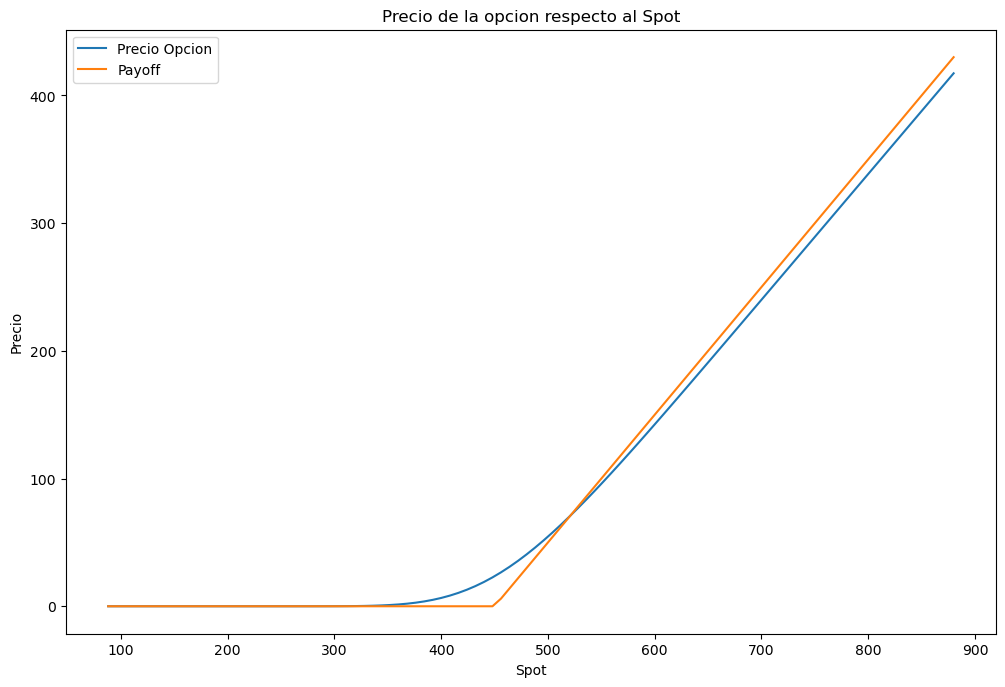

In [45]:
S_vec = np.linspace(precio_activo*.2, precio_activo*2, 100)
NPV_vec=[]
payoff_vec=[]
for S_i in S_vec:
    S.setValue(S_i)
    NPV_vec.append(opcion_europea.NPV())
    payoff_vec.append(max(S_i-precio_ejercicio,0))

plt.plot(S_vec, NPV_vec, label = 'Precio Opcion')
plt.plot(S_vec, payoff_vec, label = 'Payoff')

plt.legend()

plt.xlabel('Spot')
plt.ylabel('Precio')
plt.title('Precio de la opcion respecto al Spot')
    
plt.show()

#Vuelvo
S.setValue(precio_activo)